In [148]:
%load_ext autoreload
%autoreload 2
    

import pickle
import numpy as np 
from matplotlib import pyplot as plt
import itertools

from src.utils.generate_query import generate_queries
from src.blast.hashtable_generation_inference import consensus_seq_match

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
reference_matrix = pickle.load(open('src/data/reference_matrix.p', 'rb'))

# Examples generations

Generate easy/hard cases of length 100:

- very hard case: the max probability is less than 0.7
- hard case: the max probabiity is between 0.7 and 0.8
- intermediate case: the max probability is between 0.8 and 0.9
- easy case: the max probability is larger than 0.9

For each case, randomly select 100 position, sample 100 sequences over each position

In [4]:

max_prob_reference_matrix = np.max(reference_matrix, axis=1)
max_probs_ma = moving_average(max_prob_reference_matrix, 100)



very_hard_cases = np.where(max_probs_ma < 0.7)[0]
hard_cases = np.where((max_probs_ma >= 0.7)&(max_probs_ma < 0.8))[0]
intermediate_cases = np.where((max_probs_ma >= 0.8)&(max_probs_ma < 0.9))[0]
easy_cases = np.where(max_probs_ma >= 0.9)[0]

In [5]:
very_hard_examples = list(very_hard_cases)

np.random.shuffle(hard_cases)
hard_examples = list(hard_cases[:100])

np.random.shuffle(intermediate_cases)
intermediate_examples = list(intermediate_cases[:100])

np.random.shuffle(easy_cases)
easy_examples = list(easy_cases[:100])

very_hard_examples = generate_queries(reference_matrix, 100,  very_hard_examples, 100)
hard_examples = generate_queries(reference_matrix, 100,  hard_examples, 100)
intermediate_examples = generate_queries(reference_matrix, 100,  intermediate_examples, 100)
easy_examples = generate_queries(reference_matrix, 100,  easy_examples, 100)

# Evalutation of baseline algorithm

## 1. Evaluate seed hitting

To evaluate seed hitting, given seed lengh = 11, a query of length 100 have 90 chance to hit the reference sequence

hit rate per sequence = # of hits / 90


In [6]:
table_data = pickle.load(open('src/data/hashtable.p','rb'))

In [225]:
def seed_hit_evalutation(examples, table_data):
    
    results = []
    for entry in examples:

        label_pos = entry['pos']
        query = entry['query']    
        output = consensus_seq_match(table_data, query)
        entry['seed_result'] = output
        match_num = 0
        for d in output:
            expected_match = d['query_idx']+ label_pos 
            match= expected_match in d['db_indices']
            if match:
                match_num += 1    
        acc = match_num / 90
        results.append(acc)
    return results


In [226]:
easy_acc = seed_hit_evalutation(easy_examples, table_data)
intermediate_acc = seed_hit_evalutation(intermediate_examples, table_data)
hard_acc = seed_hit_evalutation(hard_examples, table_data)
very_hard_acc = seed_hit_evalutation(very_hard_examples, table_data)

In [227]:
data = [
    len([x for x in very_hard_acc if x==0]) /len(very_hard_acc), 
    len([x for x in hard_acc if x==0]) /len(very_hard_acc), 
    len([x for x in intermediate_acc if x==0]) /len(very_hard_acc), 
    len([x for x in easy_acc if x==0]) /len(very_hard_acc)
]

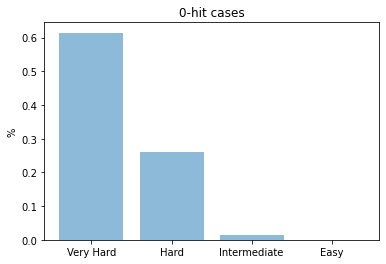

In [228]:
objects = ('Very Hard', 'Hard', 'Intermediate', 'Easy')
y_pos = np.arange(len(objects))
performance = data

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('%')
plt.title('0-hit cases')

plt.show()


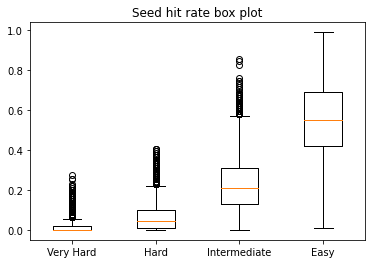

In [311]:
data = [very_hard_acc, hard_acc, intermediate_acc, easy_acc]
plt.boxplot(data)
plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
plt.title('Seed hit rate box plot')
plt.show()

## 2. Evaluate ungapped extention

this section can be evaluated independent of the seed hitting performance

for each query, we assume perfect seed hitting: every query has 90 hits at correct position, so for each sequence we do 90 ungapped extention, compute extention length

In [72]:
from src.blast.ungapped_extension import ungapped_extension, UNGAPPED_SCORE_ALGORITHM

In [96]:
from src.utils.utils import sequence_one_hot


In [216]:
all_data = []
for idx, example  in enumerate(intermediate_examples):

    query = example['query']
    label_pos = example['pos']
    entry = [
        {'query_idx':idx, 'db_indices': [idx+label_pos]} for 
        idx in range(90)
    ]
    data = sum(list(ungapped_extension(query, entry, 'src/data/reference_matrix.p', 11, 1, 'sum_proba_score').values()), [])
    all_data.append(data)
all_data = list(itertools.chain(*all_data))
intermediate_gap_coverage = [x[0][1]-x[0][0]+1 for x in all_data]

In [244]:
def evaluate_ungapped_extenison(examples, delta=1, use_seed_result=False):
    
    all_data = []
    for idx, example  in enumerate(examples):

        query = example['query']
        label_pos = example['pos']
        if not use_seed_result:
            seed_result = [
                {'query_idx':idx, 'db_indices': [idx+label_pos]} for 
                idx in range(90)
            ]
        else:
            seed_result = example['seed_result']
        data = sum(list(ungapped_extension(query, seed_result, 'src/data/reference_matrix.p', 11, delta, 'sum_proba_score').values()), [])
        
        if use_seed_result:
            key = 'original'
        else:
            key= 'simulated'
        example['ungapped_extension_result_{0}_delta_{1}'.format(key, delta)] = data
        all_data.append(data)
    all_data = list(itertools.chain(*all_data))
    ungapped_coverage = [x[0][1]-x[0][0]+1 for x in all_data]
    return ungapped_coverage

In [245]:

very_hard_ungapped_coverage = evaluate_ungapped_extenison(very_hard_examples)
hard_ungapped_coverage = evaluate_ungapped_extenison(hard_examples)
intermediate_ungapped_coverage = evaluate_ungapped_extenison(intermediate_examples)
easy_ungapped_coverage = evaluate_ungapped_extenison(easy_examples)

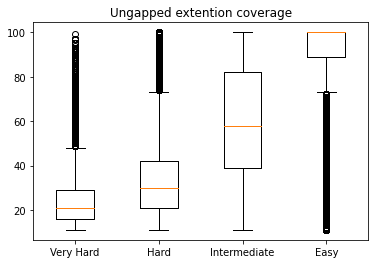

In [312]:
data = [very_hard_ungapped_coverage, hard_ungapped_coverage, intermediate_ungapped_coverage, easy_ungapped_coverage]
plt.boxplot(data)
plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])

plt.title('Ungapped extention coverage')
plt.show()

In [251]:
_ = evaluate_ungapped_extenison(very_hard_examples, use_seed_result=True)
_ = evaluate_ungapped_extenison(hard_examples, use_seed_result=True)
_ = evaluate_ungapped_extenison(intermediate_examples, use_seed_result=True)
_ = evaluate_ungapped_extenison(easy_examples, use_seed_result=True)

[100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 11,
 11,
 11,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 11,
 11,
 12,
 12,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 11,
 11,
 16,
 16,
 12,
 11,
 11,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 11,
 16,
 16,
 12,
 11,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100

Evaluate ungapped extention using matches computed from step 1

In [291]:
very_hard_examples_coverage2 = []
for example in very_hard_examples:
    range1 = (example['pos'] , example['pos']+100)
    for entry in example['ungapped_extension_result_original_delta_1']:
        range2 = entry[0]
        overlap = compute_overlap(range1, range2)
        if overlap >0 :
            very_hard_examples_coverage2.append(overlap)
            
hard_examples_coverage2 = []
for example in hard_examples:
    range1 = (example['pos'] , example['pos']+100)
    for entry in example['ungapped_extension_result_original_delta_1']:
        range2 = entry[0]
        overlap = compute_overlap(range1, range2)
        if overlap >0 :
            hard_examples_coverage2.append(overlap)
    
intermediate_examples_coverage2 = []
for example in intermediate_examples:
    range1 = (example['pos'] , example['pos']+100)
    for entry in example['ungapped_extension_result_original_delta_1']:
        range2 = entry[0]
        overlap = compute_overlap(range1, range2)
        if overlap >0 :
            intermediate_examples_coverage2.append(overlap)
            
easy_examples_coverage2 = []
for example in easy_examples:
    range1 = (example['pos'] , example['pos']+100)
    for entry in example['ungapped_extension_result_original_delta_1']:
        range2 = entry[0]
        overlap = compute_overlap(range1, range2)
        if overlap >0 :
            easy_examples_coverage2.append(overlap)

In [257]:
def compute_overlap(range1, range2):
    
    overlap = min(range1[1], range2[1]) - max(range1[0], range2[0])
    overlap = max(overlap, 0)
    return overlap

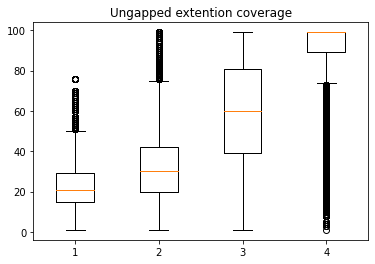

In [292]:
data = [very_hard_examples_coverage2, hard_examples_coverage2, intermediate_examples_coverage2, easy_examples_coverage2]
plt.boxplot(data)

plt.title('Ungapped extention coverage')
plt.show()